# This notebook contian code to load yolov3 tiny crowdperson model loading and inference using openvino runtime


In [3]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
#print("Cuda version: {}".format(tf_build_info.cuda_version_number))
#print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

TensorFlow version: 2.7.0
Eager execution: True
Keras version: 2.7.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [4]:
from keras.models import load_model, Model
from keras.engine.base_layer import Layer
import tensorflow as tf
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return (inputs* tf.math.tanh(mysoftplus(inputs)))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    

yolo_model = load_model("D:/ModelGraph/Intrusion_Detection/yolov4-crowdperson-detection.h5",custom_objects={"Mish":Mish})

In [1]:
#load model from saved_model instead of h5
from keras.models import load_model, Model
yolo_model = load_model("../../bialcrowd")
#yolo_model.save('bialcrowd')

2022-07-01 20:40:44.289098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 20:40:44.289178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-01 20:40:46.443086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-01 20:40:46.443143: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 20:40:46.443164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BLPCE106): /proc/driver/nvidia/version does not exist
2022-07-01 20:40:46.443339: I tensorflow/core/platform/cpu_feature_g

In [1]:
from keras import backend as K
import numpy as np
anchors = '12, 16,  19, 36,  40, 28,  36, 75,  76, 55,  72, 146,  142, 110,  192, 243,  459, 401'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
class_names = ['head' ,'person']


2022-07-01 20:56:10.930640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 20:56:10.930700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [28]:
from PIL import ImageDraw, Image ,ImageFont
import cv2
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    img_width, img_height = image.size
    w, h = size
    scale = min(w / img_width, h / img_height)
    nw = int(img_width * scale)
    nh = int(img_height * scale)
    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))
    return new_image
frame = cv2.imread('images/0004.jpg')
#image  = Image.open('images/0001.jpg')
image = Image.fromarray(frame)
print(image.size)
model_image_size = (416, 416)
boxed_image = letterbox_image(image, model_image_size)
image_data = np.array(boxed_image, dtype='float32')
print(image_data.shape)
image_data /= 255.
image_data = np.expand_dims(image_data, 0)

(960, 720)
(416, 416, 3)


/tmp/ipykernel_18019/3748252550.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw, nh), Image.BICUBIC)


In [29]:
yolo_model.summary() 

NameError: name 'yolo_model' is not defined

In [3]:
def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=200,
              score_threshold=.3,
              iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


In [4]:

def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[...,::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[...,::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs


In [5]:
def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


In [6]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


In [16]:
import tensorflow as tf
#yhat = yolo_model.predict(image_data)
#t = tf.convert_to_tensor(value=t, dtype='float32')
ypredict = [tf.convert_to_tensor(value=a, dtype='float32')  for a in yhat]
out_boxes, out_scores, out_classes  = yolo_eval(ypredict,anchors, len(class_names), (720, 960))
out_boxes= out_boxes.numpy()
out_scores = out_scores.numpy()
out_classes = out_classes.numpy()
image_orig =image_data * 255
image_orig = np.squeeze(image_orig, axis=0).astype('uint8')
image_orig = frame
classId_list = class_names
person_coordinates = dict()
for classids in classId_list:
    person_coordinates[classids] = []
person_boxes = []
person_scores = []
person_classes = []
(h, w) = image_orig.shape[:2]
color = (0,255,0)
if len(out_boxes) > 0:
    for i, c in reversed(list(enumerate(out_classes))):
        box = out_boxes[i]
        score = round(out_scores[i],2)
        if score > 0.3 and class_names[c] in classId_list:
            top, left, bottom, right = box
            startY = int(max(0, np.floor(top + 0.5).astype('int32')))
            startX = int(max(0, np.floor(left + 0.5).astype('int32')))
            endY = int(min(image.size[1], np.floor(bottom + 0.5).astype('int32')))
            endX = int(min(image.size[0], np.floor(right + 0.5).astype('int32')))
            if class_names[c] not in list(person_coordinates.keys()):
                person_coordinates[class_names[c]]=[(startX, startY, endX, endY,box)]
            else:
                person_coordinates[class_names[c]].append((startX, startY, endX, endY,box))
                    
            if class_names[c] == classId_list[0]:
                if classId_list[0] =="person":
                    color = (0, 0, 255)
                    person_boxes.append([startY/h,startX/w,endY/h,endX/w])
                    person_scores.append(score)
                    person_classes.append(c)
                elif classId_list[0] =="head":
                    color = (255,0,0)
                    face_height = endY-startY
                    face_width = endX-startX
                    #person_boxes.append([startY/h,max(0,int(startX-face_width/3))/w,min(h-1,int(endY+foot_coordinates_multiplication_factor*face_height))/h,min(w-1,int(endX+face_width/3))/w])
                    person_scores.append(score)
                    person_classes.append(c)
                    
            cv2.rectangle(image_orig, (startX, startY), (endX, endY), color, 2)
            

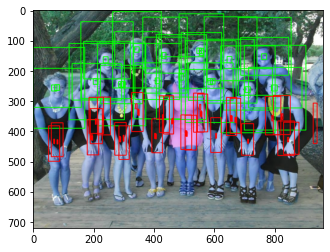

In [17]:
from matplotlib import pyplot
%matplotlib inline
pyplot.imshow(image_orig)

# The code below will not work so skip them

In [11]:
# converting model using openvino model optimizer
!mo --saved_model_dir ../../bialcrowd --input_shape [1,416,416,3] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/mnt/d/Queue_managment_debug/Yolov-4-master/Github backup/CROWD-PERSON-DETECTION/.
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,416,416,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Front

In [31]:
import tensorflow as tf
#yhat = yolo_model.predict(image_data)
#t = tf.convert_to_tensor(value=t, dtype='float32')
ypredict = [tf.convert_to_tensor(value=a, dtype='float32')  for a in yhat]
out_boxes, out_scores, out_classes  = yolo_eval(ypredict,anchors, len(class_names), (720, 960))
out_boxes= out_boxes.numpy()
out_scores = out_scores.numpy()
out_classes = out_classes.numpy()
image_orig =image_data * 255
image_orig = np.squeeze(image_orig, axis=0).astype('uint8')
image_orig = frame
classId_list = class_names
person_coordinates = dict()
for classids in classId_list:
    person_coordinates[classids] = []
person_boxes = []
person_scores = []
person_classes = []
(h, w) = image_orig.shape[:2]
color = (0,255,0)
if len(out_boxes) > 0:
    for i, c in reversed(list(enumerate(out_classes))):
        box = out_boxes[i]
        score = round(out_scores[i],2)
        if score > 0.3 and class_names[c] in classId_list:
            top, left, bottom, right = box
            startY = int(max(0, np.floor(top + 0.5).astype('int32')))
            startX = int(max(0, np.floor(left + 0.5).astype('int32')))
            endY = int(min(image.size[1], np.floor(bottom + 0.5).astype('int32')))
            endX = int(min(image.size[0], np.floor(right + 0.5).astype('int32')))
            if class_names[c] not in list(person_coordinates.keys()):
                person_coordinates[class_names[c]]=[(startX, startY, endX, endY,box)]
            else:
                person_coordinates[class_names[c]].append((startX, startY, endX, endY,box))
                    
            if class_names[c] == classId_list[0]:
                if classId_list[0] =="person":
                    color = (0, 0, 255)
                    person_boxes.append([startY/h,startX/w,endY/h,endX/w])
                    person_scores.append(score)
                    person_classes.append(c)
                elif classId_list[0] =="head":
                    color = (255,0,0)
                    face_height = endY-startY
                    face_width = endX-startX
                    #person_boxes.append([startY/h,max(0,int(startX-face_width/3))/w,min(h-1,int(endY+foot_coordinates_multiplication_factor*face_height))/h,min(w-1,int(endX+face_width/3))/w])
                    person_scores.append(score)
                    person_classes.append(c)
                    
            cv2.rectangle(image_orig, (startX, startY), (endX, endY), color, 2)
            

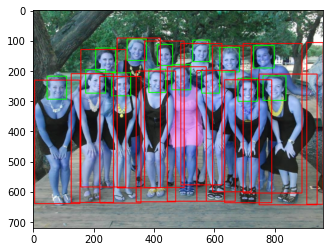

In [32]:
from matplotlib import pyplot
%matplotlib inline
pyplot.imshow(image_orig)

In [34]:
#Inference on converted model uisng openvino runtime
import openvino.runtime as ov
core = ov.Core()
model_name = "saved_model.xml"
model = core.compile_model(model_name, "AUTO")
input_layer = next(iter(model.inputs))
print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")
output_layer = next(iter(model.outputs))
print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

infer_request = model.create_infer_request()
#Create tensor from external memory
input_tensor = ov.Tensor(array=image_data, shared_memory=True)
# Set input tensor for model with one input
infer_request.set_input_tensor(input_tensor)
infer_request.start_async()
infer_request.wait()
# Get output tensor for model with one output
ypredict_open = []
output = infer_request.get_output_tensor(0)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(1)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(2)
output_buffer = output.data
ypredict_open.append(output_buffer)
[print(a.shape) for a in ypredict_open]
yhat=[ypredict_open[1],ypredict_open[0],ypredict_open[2]]
# output_buffer[] - accessing output tensor data

input precision: <Type: 'float32'>
input shape: {1, 416, 416, 3}
output precision: <Type: 'float32'>
output shape: {1, 26, 26, 21}
(1, 26, 26, 21)
(1, 13, 13, 21)
(1, 52, 52, 21)


In [36]:
print(model.inputs[0].names)
#print(model.input('input_0'), model.input('Func/StatefulPartitionedCall/input/_0:0'),model.input('input_0:0'))

{'input_1', 'input_1:0', 'Func/StatefulPartitionedCall/input/_0:0'}


Openvino support integrating preprocess step inside openvino IR.Now we integrate preprocess inside our converted model https://docs.openvino.ai/latest/openvino_docs_OV_UG_Preprocessing_Overview.html#

In [37]:
import openvino.runtime as ov
from openvino.preprocess import PrePostProcessor,ColorFormat,ResizeAlgorithm
from openvino.runtime import Layout, Type
from openvino.runtime.passes import Manager
core = ov.Core()
model = core.read_model("saved_model.xml")
h,w= 720,960
ppp = PrePostProcessor(model)
input_name= 'input_1'
ppp.input(input_name).tensor() \
        .set_element_type(Type.u8) \
        .set_shape([1, h, w, 3]) \
        .set_layout(Layout('NHWC')) \
        .set_color_format(ColorFormat.RGB)

ppp.input(input_name).preprocess() \
    .convert_element_type(Type.f32) \
    .convert_color(ColorFormat.RGB) \
    .resize(ResizeAlgorithm.RESIZE_LINEAR) \
    .scale(255)
print(f'Dump preprocessor: {ppp}')
model = ppp.build()
pass_manager = Manager()
pass_manager.register_pass(pass_name="Serialize",
                           xml_path='saved_model_preprocess.xml',
                           bin_path='saved_model_preprocess.bin')
pass_manager.run_passes(model)

Dump preprocessor: Input "Func/StatefulPartitionedCall/input/_0:0" (color RGB):
    User's input tensor: {1,720,960,3}, [N,H,W,C], u8
    Model's expected tensor: {1,416,416,3}, [N,H,W,C], f32
    Pre-processing steps (4):
      convert type (f32): ({1,720,960,3}, [N,H,W,C], u8, RGB) -> ({1,720,960,3}, [N,H,W,C], f32, RGB)
      convert color (RGB): ({1,720,960,3}, [N,H,W,C], f32, RGB) -> ({1,720,960,3}, [N,H,W,C], f32, RGB)
      resize to model width/height: ({1,720,960,3}, [N,H,W,C], f32, RGB) -> ({1,416,416,3}, [N,H,W,C], f32, RGB)
      scale (255): ({1,416,416,3}, [N,H,W,C], f32, RGB) -> ({1,416,416,3}, [N,H,W,C], f32, RGB)



In [82]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
image = load_img('images/0004.jpg')
image = img_to_array(image)
image = expand_dims(image, 0)
image = image.astype('uint8')
print(image.dtype)
frame = cv2.imread('images/0004.jpg')
image = Image.fromarray(frame)
image_data = np.array(image)
image_data = np.expand_dims(image_data, 0)

uint8


In [87]:
# Running inference on inegrated model
import openvino.runtime as ov
core = ov.Core()
model_name = "saved_model_preprocess.xml"
model = core.compile_model(model_name, "AUTO")
input_layer = next(iter(model.inputs))
print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")
output_layer = next(iter(model.outputs))
print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

infer_request = model.create_infer_request()
#Create tensor from external memory
input_tensor = ov.Tensor(array=image_data, shared_memory=True)
# Set input tensor for model with one input
infer_request.set_input_tensor(input_tensor)
infer_request.start_async()
infer_request.wait()
# Get output tensor for model with one output
ypredict_open = []
output = infer_request.get_output_tensor(0)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(1)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(2)
output_buffer = output.data
ypredict_open.append(output_buffer)
[print(a.shape) for a in ypredict_open]
yhat=[ypredict_open[1],ypredict_open[0],ypredict_open[2]]

input precision: <Type: 'uuint8_t8'>
input shape: {1, 720, 960, 3}
output precision: <Type: 'float32'>
output shape: {1, 26, 26, 21}
(1, 26, 26, 21)
(1, 13, 13, 21)
(1, 52, 52, 21)


In [88]:
import tensorflow as tf
#yhat = yolo_model.predict(image_data)
#t = tf.convert_to_tensor(value=t, dtype='float32')
ypredict = [tf.convert_to_tensor(value=a, dtype='float32')  for a in yhat]
out_boxes, out_scores, out_classes  = yolo_eval(ypredict,anchors, len(class_names), (720, 960))
out_boxes= out_boxes.numpy()
out_scores = out_scores.numpy()
out_classes = out_classes.numpy()
image_orig =frame
classId_list = class_names
person_coordinates = dict()
for classids in classId_list:
    person_coordinates[classids] = []
person_boxes = []
person_scores = []
person_classes = []
(h, w) = image_orig.shape[:2]
color = (0,255,0)
if len(out_boxes) > 0:
    for i, c in reversed(list(enumerate(out_classes))):
        box = out_boxes[i]
        score = round(out_scores[i],2)
        if score > 0.3 and class_names[c] in classId_list:
            top, left, bottom, right = box
            startY = int(max(0, np.floor(top + 0.5).astype('int32')))
            startX = int(max(0, np.floor(left + 0.5).astype('int32')))
            endY = int(min(image.size[1], np.floor(bottom + 0.5).astype('int32')))
            endX = int(min(image.size[0], np.floor(right + 0.5).astype('int32')))
            if class_names[c] not in list(person_coordinates.keys()):
                person_coordinates[class_names[c]]=[(startX, startY, endX, endY,box)]
            else:
                person_coordinates[class_names[c]].append((startX, startY, endX, endY,box))
                    
            if class_names[c] == classId_list[0]:
                if classId_list[0] =="person":
                    color = (0, 0, 255)
                    person_boxes.append([startY/h,startX/w,endY/h,endX/w])
                    person_scores.append(score)
                    person_classes.append(c)
                elif classId_list[0] =="head":
                    color = (255,0,0)
                    face_height = endY-startY
                    face_width = endX-startX
                    #person_boxes.append([startY/h,max(0,int(startX-face_width/3))/w,min(h-1,int(endY+foot_coordinates_multiplication_factor*face_height))/h,min(w-1,int(endX+face_width/3))/w])
                    person_scores.append(score)
                    person_classes.append(c)
                    
            cv2.rectangle(image_orig, (startX, startY), (endX, endY), color, 2)
            

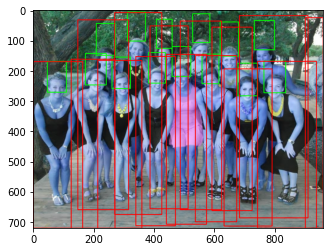

In [89]:
from matplotlib import pyplot
%matplotlib inline
pyplot.imshow(image_orig)